In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import statsmodels.api as sm
import graphviz

Data Preprocessing

In [24]:
data_path = r"C:\Users\trush\OneDrive\Documents\WFU Grad School Info\BAN 6025 Machine Learning\Organics Project\organics.csv"
organic_df = pd.read_csv(data_path)
organic_df = organic_df.drop(columns=['ID'])
organic_df.head()

,DemAffl,DemAge,DemCluster,DemClusterGroup,DemGender,DemReg,DemTVReg,PromClass,PromSpend,PromTime,TargetBuy,TargetAmt
0,10.0,76.0,16.0,C,U,Midlands,Wales & West,Gold,16000.00,4.0,0,0
1,4.0,49.0,35.0,D,U,Midlands,Wales & West,Gold,6000.00,5.0,0,0
2,5.0,70.0,27.0,D,F,Midlands,Wales & West,Silver,0.02,8.0,1,1
3,10.0,65.0,51.0,F,M,Midlands,Midlands,Tin,0.01,7.0,1,1
4,11.0,68.0,4.0,A,F,Midlands,Midlands,Tin,0.01,8.0,0,0


Find Missing Values

In [25]:
def find_missing(df):
    return (df.isna().sum() / len(df)) * 100

DemAge, DemCluster, DemClusterGroup, DemTVReg, DemReg: Cannot make an accurate estimation, so I am going to drop missing values

In [26]:
columns = ['DemAge', 'DemCluster', 'DemClusterGroup', 'DemTVReg', 'DemReg']
organic_df.dropna(subset=columns, inplace=True)
#organic_df = organic_df[organic_df['DemAge'].notna()]

DemAffl: Affluence Grade, I am going to fill the missing values with the mean

In [27]:
organic_df['DemAffl'] = organic_df['DemAffl'].fillna(np.mean(organic_df['DemAffl']))

PromTime: Fill with the mean

In [28]:
organic_df['PromTime'] = organic_df['PromTime'].fillna(np.mean(organic_df['PromTime']))

DemGender: There is an Unknown Column for Gender (U). Will fill na values with 'U'

In [29]:
organic_df['DemGender'] = organic_df['DemGender'].fillna('U')

In [30]:
find_missing(organic_df)

DemAffl            0.0
DemAge             0.0
DemCluster         0.0
DemClusterGroup    0.0
DemGender          0.0
DemReg             0.0
DemTVReg           0.0
PromClass          0.0
PromSpend          0.0
PromTime           0.0
TargetBuy          0.0
TargetAmt          0.0
dtype: float64

Distribution of Classes

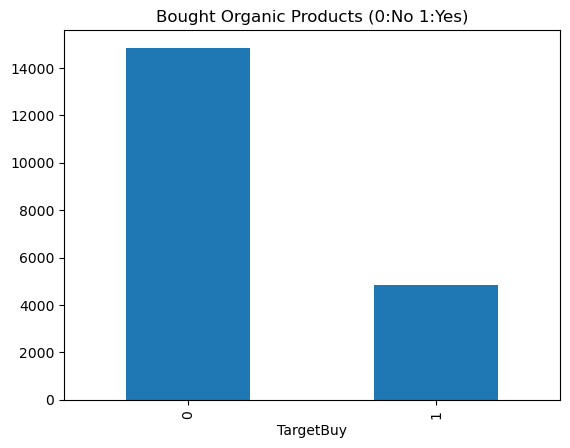

In [31]:
class_counts = organic_df['TargetBuy'].value_counts()
class_counts.plot(kind='bar')
plt.title('Bought Organic Products (0:No 1:Yes)')
plt.show()

Correlation Matrix for Numeric Variables

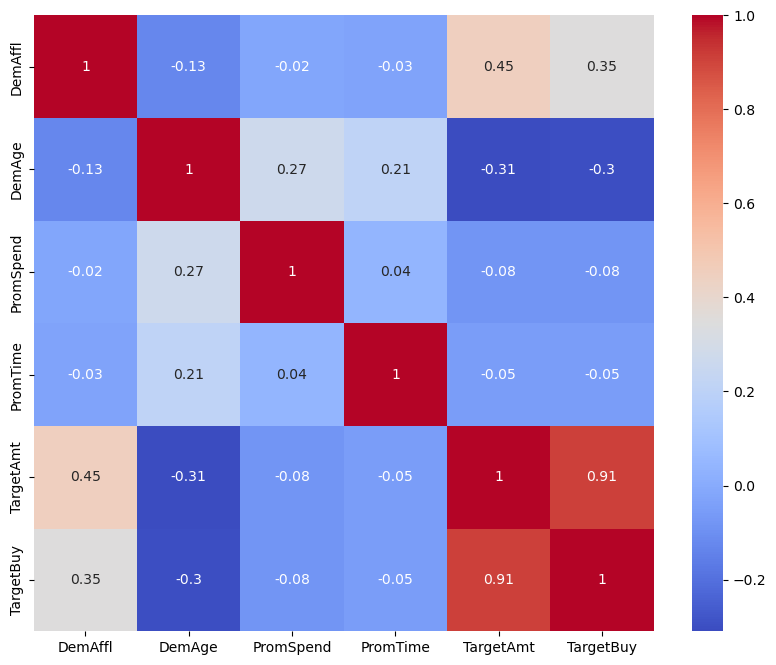

In [32]:
numeric = ['DemAffl', 'DemAge', 'PromSpend', 'PromTime', 'TargetAmt', 'TargetBuy']
numeric_variables = organic_df[numeric]

correlation_matrix = numeric_variables.corr().round(2)

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [33]:
organic_df = organic_df.drop(columns=['TargetAmt'])

Bar Plots for Nominal Data

<Figure size 1000x800 with 0 Axes>

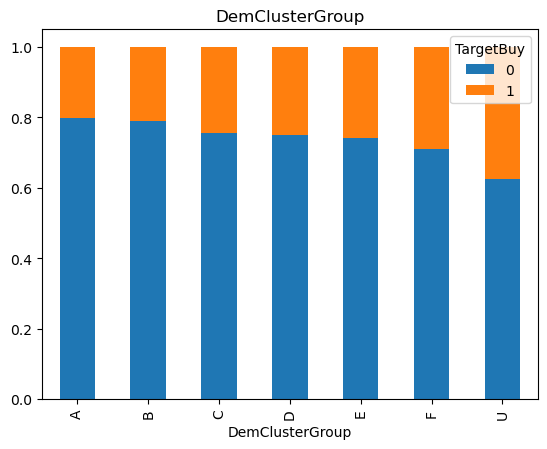

<Figure size 1000x800 with 0 Axes>

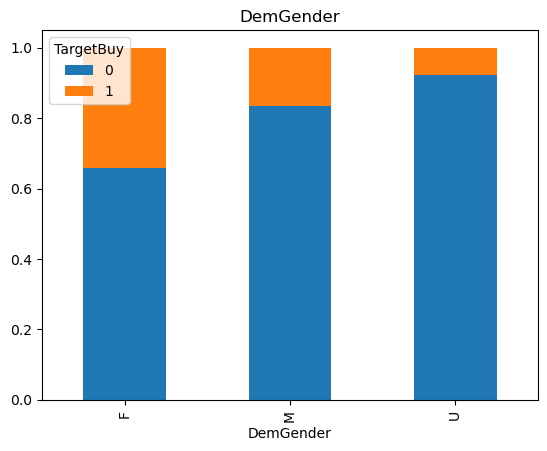

<Figure size 1000x800 with 0 Axes>

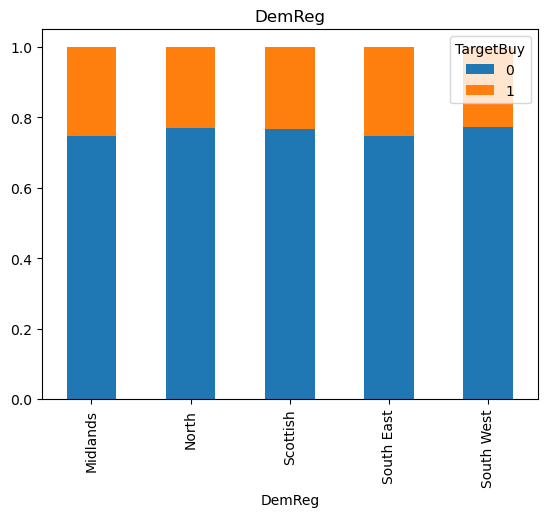

<Figure size 1000x800 with 0 Axes>

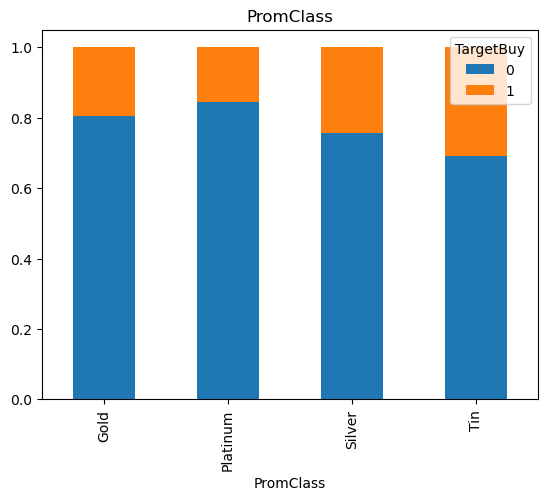

<Figure size 1000x800 with 0 Axes>

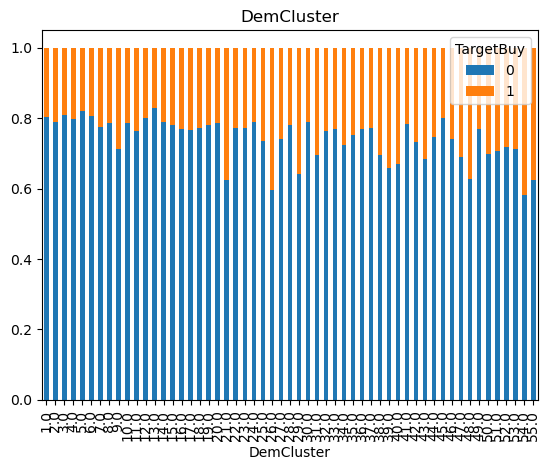

<Figure size 1000x800 with 0 Axes>

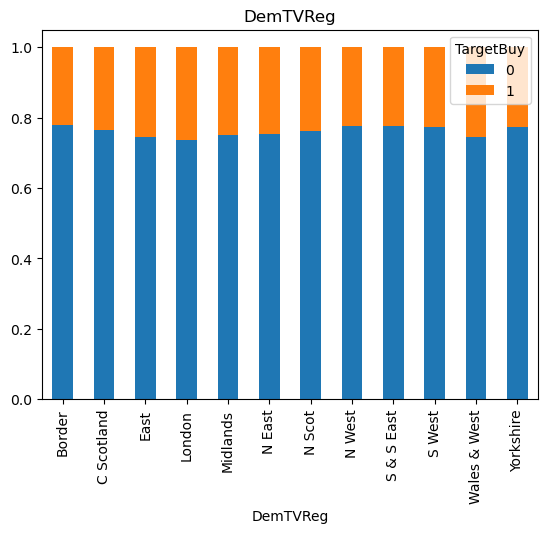

In [34]:
nominal_columns = ['DemClusterGroup', 'DemGender', 'DemReg', 'PromClass', 'DemCluster', 'DemTVReg']


for column in nominal_columns:
    plt.figure(figsize=(10,8))
    category_target = organic_df.groupby(column)['TargetBuy'].value_counts(normalize=True).unstack()
    category_target.plot(kind='bar', stacked=True)
    plt.title(column)
    plt.show()

Full Model 

In [35]:
X = organic_df.drop(columns=['TargetBuy'])
y = organic_df['TargetBuy']

X = pd.get_dummies(X, columns=nominal_columns, drop_first=True, dtype='float')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)


# CatBoost

![alt text](cat.jpg)

In [36]:
cat_boost = CatBoostClassifier(iterations=500, learning_rate=0.03, depth=6, random_state=69)
cat_boost.fit(X_train, y_train)

0:	learn: 0.6761993	total: 7.82ms	remaining: 3.9s
1:	learn: 0.6575475	total: 16.7ms	remaining: 4.15s
2:	learn: 0.6411640	total: 23.7ms	remaining: 3.93s
3:	learn: 0.6250642	total: 31.1ms	remaining: 3.86s
4:	learn: 0.6104669	total: 37.5ms	remaining: 3.72s
5:	learn: 0.5970571	total: 45.8ms	remaining: 3.77s
6:	learn: 0.5832590	total: 51.8ms	remaining: 3.65s
7:	learn: 0.5711789	total: 57.3ms	remaining: 3.52s
8:	learn: 0.5619203	total: 64.5ms	remaining: 3.52s
9:	learn: 0.5510852	total: 70.4ms	remaining: 3.45s
10:	learn: 0.5425129	total: 77ms	remaining: 3.42s
11:	learn: 0.5339004	total: 83.3ms	remaining: 3.39s
12:	learn: 0.5274202	total: 89.2ms	remaining: 3.34s
13:	learn: 0.5197418	total: 95.5ms	remaining: 3.32s
14:	learn: 0.5139074	total: 102ms	remaining: 3.3s
15:	learn: 0.5084687	total: 109ms	remaining: 3.28s
16:	learn: 0.5033954	total: 115ms	remaining: 3.26s
17:	learn: 0.4971385	total: 120ms	remaining: 3.23s
18:	learn: 0.4914178	total: 127ms	remaining: 3.21s
19:	learn: 0.4858713	total: 133

In [37]:
cb_train_pred = cat_boost.predict(X_train)
cb_test_pred = cat_boost.predict(X_test)

cb_train_prob = cat_boost.predict_proba(X_train)
cb_test_prob = cat_boost.predict_proba(X_test)

In [38]:
def metrics(y, x):
    print(f'Accuracy: {accuracy_score(y,x)}')
    print(f'Precision: {precision_score(y,x)}')
    print(f'Recall: {recall_score(y,x)}')

In [39]:
print('Train Set')
metrics(y_train, cb_train_pred)

print('Test Set')
metrics(y_test, cb_test_pred)

Train Set
Accuracy: 0.8382465057179161
Precision: 0.76050753370341
Recall: 0.4968911917098446
Test Set
Accuracy: 0.8170731707317073
Precision: 0.6978998384491115
Recall: 0.44766839378238343


# Random Forest

In [42]:
random_forest = RandomForestClassifier(n_estimators=100, max_features=3, max_depth=None, min_samples_leaf=1, random_state=69)

random_forest.fit(X_train, y_train)

RandomForestClassifier(max_features=3, random_state=69)

In [43]:
rf_train_pred = random_forest.predict(X_train)
rf_test_pred = random_forest.predict(X_test)

rf_train_prob = random_forest.predict_proba(X_train)
rf_test_prob = random_forest.predict_proba(X_test)

In [44]:
print('Train Set')
metrics(y_train, rf_train_pred)

print('Test Set')
metrics(y_test, rf_test_pred)

Train Set
Accuracy: 0.9996188055908514
Precision: 0.9994815966822188
Recall: 0.9989637305699481
Test Set
Accuracy: 0.8074186991869918
Precision: 0.705765407554672
Recall: 0.36787564766839376


# Decision Tree

In [46]:
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=25, min_samples_leaf=10, ccp_alpha=0.001)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=25,
                       min_samples_leaf=10)

In [47]:
dt_train_pred = decision_tree.predict(X_train)
dt_test_pred = decision_tree.predict(X_test)

dt_train_prob = decision_tree.predict_proba(X_train)
dt_test_prob = decision_tree.predict_proba(X_test)

In [48]:
print('Train Set')
metrics(y_train, dt_train_pred)

print('Test Set')
metrics(y_test, dt_test_pred)

Train Set
Accuracy: 0.819440914866582
Precision: 0.75
Recall: 0.3955958549222798
Test Set
Accuracy: 0.8158028455284553
Precision: 0.7380952380952381
Recall: 0.3854922279792746


Visualize the Tree

In [52]:
dot_data = export_graphviz(decision_tree=decision_tree, filled=True, rounded=True, feature_names=X.columns, class_names=['0', '1'])
graph = graphviz.Source(dot_data)
graph.render('Decision_Tree_Default')

'Decision_Tree_Default.pdf'